<h1>Demand forecasting with BigQuery and TensorFlow</h1>

In this notebook, we will develop a machine learning model to predict the demand for taxi cabs in New York.

To develop the model, we will need to get historical data of taxicab usage. This data exists in BigQuery. Let's start by looking at the schema.

In [12]:
import datalab.bigquery as bq
import pandas as pd
import numpy as np
import shutil

In [2]:
%projects set drwgry-proj

In [1]:
%bigquery schema --table "drwgry-proj:sppda_2016_8.test"

<h2> Analyzing taxicab demand </h2>

Let's pull the number of trips for each day in the 2015 dataset.  We can use the BigQuery built-in Date-and-time function DAYOFYEAR (See <a href="https://cloud.google.com/bigquery/query-reference"> BigQuery query reference </a>) for a full list of such functions.

In [5]:
%sql
SELECT DAYOFYEAR(pickup_datetime) AS daynumber FROM [nyc-tlc:green.trips_2015] LIMIT 10

daynumber
120
120
120
120
149
150
150
89
89
89


<h3> Modular queries and Pandas dataframe </h3>

Let's use the total number of trips as our proxy for taxicab demand (other reasonable alternatives are total trip_distance or total fare_amount).  It is possible to predict multiple variables using Tensorflow, but for simplicity, we will stick to just predicting the number of trips.

We will give our query a name 'taxiquery' and have it use an input variable '$YEAR'. We can then invoke the 'taxiquery' by giving it a YEAR.  The to_dataframe() converts the BigQuery result into a <a href='http://pandas.pydata.org/'>Pandas</a> dataframe.

In [6]:
%%sql --module taxiquery
SELECT daynumber, COUNT(*) AS numtrips FROM
    (SELECT DAYOFYEAR(pickup_datetime) AS daynumber FROM [nyc-tlc:green.trips_$YEAR])
GROUP BY daynumber ORDER BY daynumber

In [7]:
trips = bq.Query(taxiquery, YEAR=2015).to_dataframe()
trips[:5]

,daynumber,numtrips
0,1,62943
1,2,43410
2,3,53866
3,4,41602
4,5,41923


<h3> Benchmark </h3>

Often, a reasonable estimate of something is its historical average. We can therefore benchmark our machine learning model against the historical average.

In [8]:
avg = np.mean(trips['numtrips'])
print 'Just using average={0} has RMSE of {1}'.format(avg, np.sqrt(np.mean((trips['numtrips'] - avg)**2)))

Just using average=54674.0994475 has RMSE of 10163.4654442


The mean here is about 55,000 and the root-mean-square-error (RMSE) in this case is about 10,000. In other words, if we were to estimate that there are 55,000 taxi trips on any given day, that estimate is will be off on average by about 10,000 in either direction.
  
Let's see if we can do better than this -- our goal is to make predictions of taxicab demand whose RMSE is lower than 10,000.

What kinds of things affect people's use of taxicabs?

<h2> Weather data </h2>
Grabbing Atoka, OK data


We suspect that weather influences how often people use a taxi. Perhaps someone who'd normally walk to work would take a taxi if it is very cold or rainy.

Googler <a href="https://twitter.com/felipehoffa">Felipe Hoffa</a> has made weather observations from the US National Oceanic and Atmospheric Administration <a href-="http://stackoverflow.com/questions/34804654/how-to-get-the-historical-weather-for-any-city-with-bigquery/34804655">publicly</a> available in BigQuery. Let's use that dataset and find the station number corresponding to New York's La Guardia airport.


In [7]:
%%sql
SELECT * FROM [fh-bigquery:weather_gsod.stations]
WHERE state = 'KS' AND wban != '99999' 
order by name asc

usaf,wban,name,country,fips,state,call,lat,lon,elev,begin,end
999999,13980,ANTHONY,US,US,KS,,37167.0,-98083.0,4026,19480101,19510101
999999,3043,ATWOOD-RAWLNS CO CTY CO AP,US,US,KS,KADT,39840.0,-101042.0,9117,,
724507,13981,CHANUTE MARTIN JOHNS,US,US,KS,KCNU,37670.0,-95484.0,3082,19730101,20120619
999999,13981,CHANUTE MARTIN JOHNSON AP,US,US,KS,KCNU,37670.0,-95484.0,3082,19480101,19650101
724519,93967,COFFEYVILLE MUNI,US,US,KS,KCFV,37091.0,-95566.0,2292,20060101,20120619
724504,3974,COL JAMES JABARA,US,US,KS,KAAO,37746.0,-97221.0,4328,20060101,20120619
999999,13984,CONCORDIA BLOSSER MUNI AP,US,US,KS,KCNK,39551.0,-97651.0,4523,19480101,19721231
724580,13984,CONCORDIA/BLOSSER M,US,US,KS,KCNK,39551.0,-97651.0,4523,19730101,20120619
999999,13985,DODGE CITY MUNICIPAL ARPT,US,US,KS,KDDC,37769.0,-99968.0,7900,19480101,19721231
999999,93016,DODGE CITY WBO,US,US,KS,,37750.0,-100017.0,765,18930101,19391231


<h3> Variables </h3>

Let's pull out the minimum and maximum daily temperature (in Fahrenheit) as well as the amount of rain (in inches) for La Guardia airport.

In [14]:
%%sql --module wxquery
SELECT DAYOFYEAR(TIMESTAMP('$YEAR'+mo+da)) daynumber,
       FIRST(DAYOFWEEK(TIMESTAMP('$YEAR'+mo+da))) dayofweek,
       MIN(min) mintemp, MAX(max) maxtemp, MAX(IF(prcp=99.99,0,prcp)) rain
FROM [fh-bigquery:weather_gsod.gsod$YEAR]
WHERE stn='724500' GROUP BY 1 ORDER BY daynumber asc

In [15]:
weather = bq.Query(wxquery, YEAR=2015).to_dataframe()
weather[:5]

,daynumber,dayofweek,mintemp,maxtemp,rain
0,1,5,7.0,32.0,0.00
1,2,6,17.1,37.9,0.00
2,3,7,30.0,41.0,0.00
3,4,1,10.0,41.0,0.31
4,5,2,3.9,35.1,0.00


<h3> Merge datasets </h3>

Let's use Pandas to merge (combine) the taxi cab and weather datasets day-by-day.

In [27]:
data = pd.merge(weather, trips, on='daynumber')
data[:5]

,daynumber,dayofweek,mintemp,maxtemp,rain,numtrips
0,181,3,66.2,93.2,0.0,42978
1,180,2,68.0,95.0,0.0,41397
2,179,1,62.6,89.6,0.0,54632
3,178,7,69.8,87.8,0.0,74883
4,177,6,77.0,93.2,0.0,58371


<h3> Exploratory analysis </h3>

Is there a relationship between maximum temperature and the number of trips?

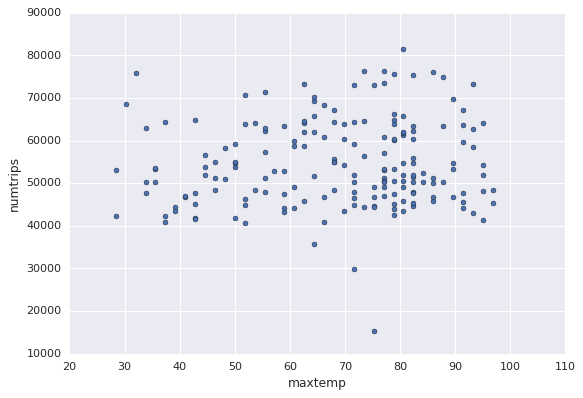

In [28]:
j = data.plot(kind='scatter', x='maxtemp', y='numtrips')

The scatterplot above doesn't look very promising. 

Is there a relationship between the day of the week and the number of trips?

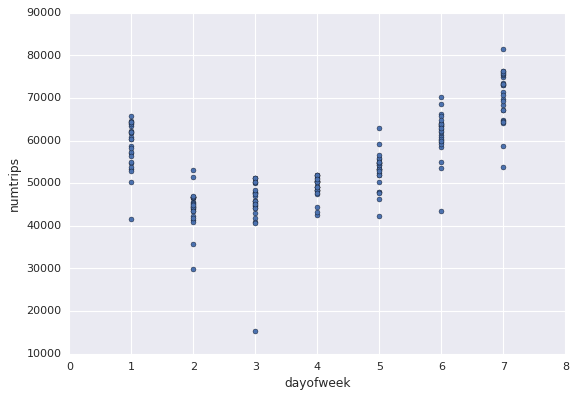

In [29]:
j = data.plot(kind='scatter', x='dayofweek', y='numtrips')

Hurrah, we seem to have found a predictor. It appears that people use taxis more later in the week. Perhaps New Yorkers make weekly resolutions to walk more and then lose their determination later in the week, or maybe it reflects tourism dynamics in New York City.

Perhaps if we took out the <em>confounding</em> effect of the day of the week, maximum temperature will start to have an effect. Let's see if that's the case:

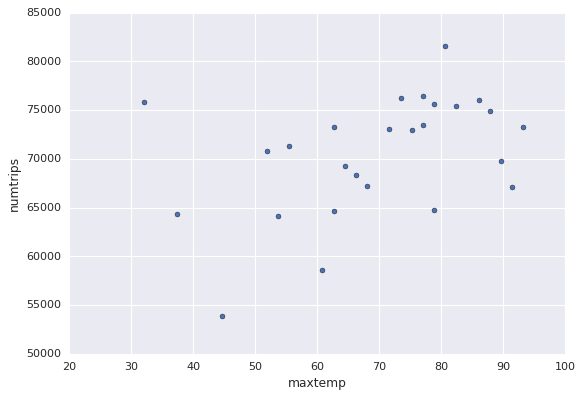

In [30]:
j = data[data['dayofweek'] == 7].plot(kind='scatter', x='maxtemp', y='numtrips')

Removing the confounding factor does seem to reflect an underlying trend around temperature. But ... the data are a little sparse, don't you think?  This is something that you have to keep in mind -- the more predictors you start to consider (here we are using two: day of week and maximum temperature), the more rows you will need so as to avoid <em> overfitting </em> the model.

<h3> Adding 2014 data </h3>

Let's add in 2014 data to the Pandas dataframe.  Note how useful it was for us to modularize our queries around the YEAR.

In [31]:
trips = bq.Query(taxiquery, YEAR=2014).to_dataframe()
weather = bq.Query(wxquery, YEAR=2014).to_dataframe()
data2014 = pd.merge(weather, trips, on='daynumber')
data2014[:5]

,daynumber,dayofweek,mintemp,maxtemp,rain,numtrips
0,365,4,28.4,39.2,0.0,67518
1,364,3,28.4,44.6,0.0,43173
2,363,2,26.6,50.0,0.0,37979
3,362,1,30.2,44.6,0.0,43055
4,361,7,33.8,55.4,0.0,46961


In [32]:
data2 = pd.concat([data, data2014])
data2.describe()

,daynumber,dayofweek,mintemp,maxtemp,rain,numtrips
count,473.000000,473.000000,473.000000,473.000000,473.0,473.000000
mean,169.653277,4.000000,53.489641,74.370402,0.0,49275.378436
std,97.437606,2.007402,16.280989,16.856105,0.0,10397.774025
min,1.000000,1.000000,12.200000,28.400000,0.0,15406.000000
25%,96.000000,2.000000,41.000000,64.400000,0.0,41439.000000
50%,155.000000,4.000000,55.400000,78.800000,0.0,47802.000000
75%,247.000000,6.000000,68.000000,87.800000,0.0,55580.000000
max,365.000000,7.000000,80.600000,100.400000,0.0,81574.000000


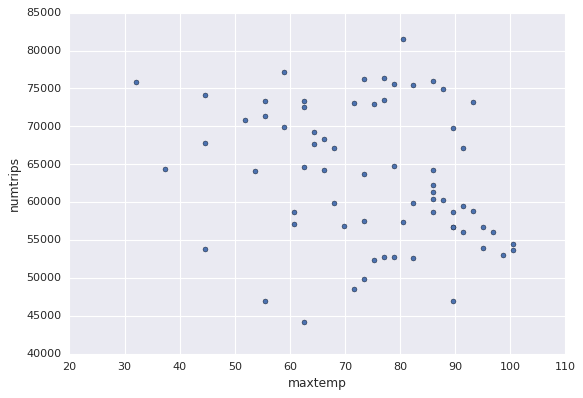

In [33]:
j = data2[data2['dayofweek'] == 7].plot(kind='scatter', x='maxtemp', y='numtrips')

The data do seem a bit more robust.  If we had more data, it would be better of course. But in this case, we only have 2014 and 2015 data, so that's what we will go with.

<h2> Machine Learning with Tensorflow </h2>

We'll use 80% of our dataset for training and 20% of the data for testing the model we have trained. Let's shuffle the rows of the Pandas dataframe so that this division is random.  The predictor (or input) columns will be every column in the database other than the number-of-trips (which is our target, or what we want to predict).

The machine learning models that we will use -- linear regression and neural networks -- both require that the input variables are numeric in nature.

The day of the week, however, is a categorical variable (i.e. Tuesday is not really greater than Monday). So, we should create separate columns for whether it is a Monday (with values 0 or 1), Tuesday, etc.

Against that, we do have limited data (remember: the more columns you use as input features, the more rows you need to have in your training dataset), and it appears that there is a clear linear trend by day of the week. So, we will opt for simplicity here and use the data as-is.  Try uncommenting the code that creates separate columns for the days of the week and re-run the notebook if you are curious about the impact of this simplification.

In [34]:
import tensorflow as tf
shuffled = data2.sample(frac=1)
# It would be a good idea, if we had more data, to treat the days as categorical variables
# with the small amount of data, we have though, the model tends to overfit
#predictors = shuffled.iloc[:,2:5]
#for day in xrange(1,8):
#  matching = shuffled['dayofweek'] == day
#  predictors.loc[matching, 'day_' + str(day)] = 1
#  predictors.loc[~matching, 'day_' + str(day)] = 0
predictors = shuffled.iloc[:,1:5]
predictors[:5]

,dayofweek,mintemp,maxtemp,rain
126,4,71.6,96.8,0.0
33,6,35.6,68.0,0.0
57,3,50.0,68.0,0.0
87,7,42.8,66.2,0.0
209,5,71.6,89.6,0.0


In [35]:
shuffled[:5]

,daynumber,dayofweek,mintemp,maxtemp,rain,numtrips
126,239,4,71.6,96.8,0.0,37955
33,332,6,35.6,68.0,0.0,47270
57,308,3,50.0,68.0,0.0,37577
87,94,7,42.8,66.2,0.0,68373
209,156,5,71.6,89.6,0.0,43049


In [36]:
targets = shuffled.iloc[:,5]
targets[:5]

126    37955
33     47270
57     37577
87     68373
209    43049
Name: numtrips, dtype: int64

Let's update our benchmark based on the 80-20 split and the larger dataset.

In [62]:
trainsize = int(len(shuffled['numtrips']) * 0.8)
avg = np.mean(shuffled['numtrips'][:trainsize])
rmse = np.sqrt(np.mean((targets[trainsize:] - avg)**2))
print 'Just using average={0} has RMSE of {1}'.format(avg, rmse)
print(targets.shape)
print(trainsize)

Just using average=49616.4365079 has RMSE of 10602.5569032
(473,)
378


<h2> Linear regression with tf.contrib.learn </h2>

We scale the number of taxicab rides by 100,000 so that the model can keep its predicted values in the [0-1] range. The optimization goes a lot faster when the weights are small numbers.  We save the weights into /tmp/trained_model and display the root mean square error on the test dataset.

In [71]:
SCALE_NUM_TRIPS = 100000.0
trainsize = int(len(shuffled['numtrips']) * 0.8)
testsize = len(shuffled['numtrips']) - trainsize
npredictors = len(predictors.columns)
noutputs = 1
tf.logging.set_verbosity(tf.logging.WARN) # change to INFO to get output every 100 steps ...
shutil.rmtree('/tmp/trained_model', ignore_errors=True) # so that we don't load weights from previous runs
estimator = tf.contrib.learn.LinearRegressor(model_dir='/tmp/trained_model',
                                             optimizer=tf.train.AdamOptimizer(learning_rate=0.1),
                                             enable_centered_bias=False,
                                             feature_columns=tf.contrib.learn.infer_real_valued_columns_from_input(predictors.values))
print "starting to train ... this will take a while ... use verbosity=INFO to get more verbose output"
estimator.fit(predictors[:trainsize].values, targets[:trainsize].values.reshape(trainsize, noutputs)/SCALE_NUM_TRIPS, steps=10000)
pred = np.multiply(list(estimator.predict(predictors[trainsize:].values)), SCALE_NUM_TRIPS )
rmse = np.sqrt(np.mean(np.power((targets[trainsize:].values - pred), 2)))
print 'LinearRegression has RMSE of {0}'.format(rmse)

tmp = targets[trainsize:].values


starting to train ... this will take a while ... use verbosity=INFO to get more verbose output
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar sum

The test error of about 11420 indicates that we are doing better with the machine learning model than we would be if we were to just use the historical average (our benchmark).

<h2> Neural network with tf.contrib.learn </h2>

Let's make a more complex model with a few hidden nodes.

In [72]:
SCALE_NUM_TRIPS = 100000.0
trainsize = int(len(shuffled['numtrips']) * 0.8)
testsize = len(shuffled['numtrips']) - trainsize
npredictors = len(predictors.columns)
noutputs = 1
tf.logging.set_verbosity(tf.logging.WARN) # change to INFO to get output every 100 steps ...
shutil.rmtree('/tmp/trained_model', ignore_errors=True) # so that we don't load weights from previous runs
estimator = tf.contrib.learn.DNNRegressor(model_dir='/tmp/trained_model',
                                          hidden_units=[5, 2],
                                          optimizer=tf.train.AdamOptimizer(learning_rate=0.01),
                                          enable_centered_bias=False,
                                          feature_columns=tf.contrib.learn.infer_real_valued_columns_from_input(predictors.values))
print "starting to train ... this will take a while ... use verbosity=INFO to get more verbose output"
estimator.fit(predictors[:trainsize].values, targets[:trainsize].values.reshape(trainsize, noutputs)/SCALE_NUM_TRIPS, steps=10000)
pred2 = np.multiply(list(estimator.predict(predictors[trainsize:].values)), SCALE_NUM_TRIPS)
rmse = np.sqrt(np.mean((targets[trainsize:].values - pred)**2))
print 'Neural Network Regression has RMSE of {0}'.format(rmse)

tmp2 = targets[trainsize:].values

starting to train ... this will take a while ... use verbosity=INFO to get more verbose output
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar sum

Using a neural network does seem to get us an additional boost in performance (11400 to 10600 when I ran it -- because of random seeds, your actual answers might be different).

<h2> Running a trained model </h2>

So, we have trained a model, and saved it to a file. Let's use this model to predict taxicab demand given the expected weather for three days.

Here we make a Dataframe out of those inputs, load up the saved model (note that we have to know the model equation -- it's not saved in the model file) and use it to predict the taxicab demand.

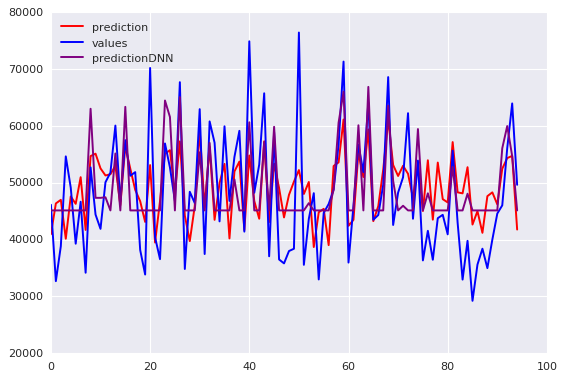

In [74]:
import matplotlib.pyplot as plt2


plt2.plot(pred,color='red', label='prediction')
plt2.plot(tmp,color='blue', label='values')
plt2.plot(pred2,color='purple', label='predictionDNN')
plt2.legend(loc='upper left')
plt2.show()

In [76]:
input = pd.DataFrame.from_dict(data = 
                               {'dayofweek' : [4, 5, 6],
                                'mintemp' : [40, 30, 70],
                                'maxtemp' : [80, 70, 80],
                                'rain' : [0, 0.8, 0]})
# read trained model from /tmp/trained_model
estimator = tf.contrib.learn.DNNRegressor(model_dir='/tmp/trained_model',
#estimator = tf.contrib.learn.LinearRegressor(model_dir='/tmp/trained_model',
                                          hidden_units=[5, 2],
                                          enable_centered_bias=False,
                                          feature_columns=tf.contrib.learn.infer_real_valued_columns_from_input(input.values))

pred = np.multiply(list(estimator.predict(input.values)), SCALE_NUM_TRIPS)
print pred

Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
[ 45291.84375     56091.38671875  55550.8125    ]


Looks like we should tell some of our taxi drivers to take the day off on Wednesday (day=4) and be there in full strength on Thursday (day=5).  No wonder -- the forecast calls for extreme weather fluctuations on Thursday.

Note that Thursdays are usually "slow" days (taxi demand peaks on the weekends), but the machine learning model tells us to expect heavy demand this particular Thursday because of the weather.